## Run Clay

This notebook shows how to run Clay model wall-to-wall(largely adopted from clay model team with minimum adjustment), from downloading imagery to training a tiny, fine-tuned head. This will include the following steps:

1. Set a location and date range of interest
2. Download Sentinel-2 imagery for this specification
3. Load the model checkpoint
4. Prepare data into a format for the model
5. Run the model on the imagery
6. Analyse the model embeddings output using PCA
7. Train a Support Vector Machine fine-tuning head

env info can be found :
https://github.com/Clay-foundation/model/tree/main

In [1]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("../..")

In [2]:
import math
import os
import requests
import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2
import rasterio

from src.module import ClayMAEModule

### Specify location and date of interest
In this example we will use a location Tirana, Albania, the capital and largest city of Albania. 

In [4]:
# get lat, lon for targeted locations

merged_df = pd.read_csv("merged_df_HDD_matchedscale.csv")
lat, lon = (merged_df["latitude"], merged_df["longitude"])
start = "2023-06-01"
end = "2024-05-31"

In [6]:
# drop the location introduces inf bounds ; epsg transformation issue; need to be solved
lat_to_drop = -3.71722
lon_to_drop = -38.54306
sub_df = merged_df[
    ~((merged_df["latitude"] == lat_to_drop) & (merged_df["longitude"] == lon_to_drop))
]
# merged_df_1.reset_index(drop=True, inplace=True)

### Get data from STAC catalog

Based on the location and date we can obtain a stack of imagery using stackstac. 

In [7]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"


# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
latest_items = {}
for _, row in sub_df.iterrows():
    lat, lon = row["latitude"], row["longitude"]

    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
        max_items=100,
        query={"eo:cloud_cover": {"lt": 10}},  # clould coverage less than 10%
    )

    all_items = search.get_all_items()
    if all_items:
        latest_item = max(all_items, key=lambda item: item.datetime)
        latest_items[(lat, lon)] = latest_item
items = list(latest_items.values())
print(f"Found {len(items)} latest items for unique (lat, lon) pairs")
# here we expect 483 items, yet get 474; need to check later

/Users/meixiangdu/miniconda3/envs/claymodel/lib/python3.11/site-packages/pystac_client/item_search.py:896: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 474 latest items for unique (lat, lon) pairs


In [26]:
# Function to read and visualize Sentinel-2 images
def plot_sentinel2_image(item, bands=("red", "green", "blue")):
    band_files = []

    # Download band files
    for band in bands:
        asset_url = item.assets[band].href  # Get the asset URL
        band_files.append(rasterio.open(asset_url))  # Open using rasterio

    # Read the bands into numpy arrays
    img_array = np.stack([band.read(1) for band in band_files], axis=-1)

    # Normalize the image (0-1) for visualization
    img_array = img_array.astype(np.float32)
    img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"Sentinel-2 Image ({', '.join(bands)})")
    plt.show()

### Create a bounding box around the point of interest

This is needed in the projection of the data so that we can generate image chips of the right size.

In [12]:
results = []

epsg_str = items[0].properties.get(
    "proj:code", "EPSG:4326"
)  # Default to WGS84, the standard geographic coordinate system
epsg = int(epsg_str.replace("EPSG:", ""))

# Define the size and ground sample distance (gsd)
size = 256  # 256 × 256 pixel image.
gsd = 10  # Each pixel represents 10 meters (Sentinel-2 resolution)

for (lat, lon), item in latest_items.items():
    # Convert point of interest into the image projection
    poidf = gpd.GeoDataFrame(
        pd.DataFrame(),
        crs="EPSG:4326",  # Assuming original coordinates are in lat/lon
        geometry=[Point(lon, lat)],
    ).to_crs(epsg)  # Convert to UTM projection

    coords = poidf.iloc[0].geometry.coords[0]

    if not all(np.isfinite(coords)):
        print(f"Invalid coordinates for lat={lat}, lon={lon}: {coords}")
        continue  # Skip this entry if coordinates are invalid

    bounds = (
        coords[0] - (size * gsd) // 2,
        coords[1] - (size * gsd) // 2,
        coords[0] + (size * gsd) // 2,
        coords[1] + (size * gsd) // 2,
    )  # 2.56 km × 2.56 km bounding box

    results.append(
        {
            "lat": lat,
            "lon": lon,
            "item_id": item,  # The item reference
            "bounds": bounds,
        }
    )

results_df = pd.DataFrame(results)

print(results_df)

          lat       lon                             item_id  \
0    24.45118  54.39696  <Item id=S2A_39RZH_20240527_0_L2A>   
1    34.52813  69.17233  <Item id=S2B_42SWD_20240530_0_L2A>   
2    41.32750  19.81889  <Item id=S2B_34TCL_20240530_1_L2A>   
3    40.18111  44.51361  <Item id=S2A_38TMK_20240425_0_L2A>   
4    -8.83682  13.23432  <Item id=S2A_33LUL_20240519_0_L2A>   
..        ...       ...                                 ...   
469 -29.12107  26.21400  <Item id=S2A_35JMH_20240528_0_L2A>   
470 -33.92584  18.42322  <Item id=S2A_34HBH_20240524_0_L2A>   
471 -15.40669  28.28713  <Item id=S2A_35LPC_20240528_0_L2A>   
472 -17.82772  31.05337  <Item id=S2A_36KTF_20240525_1_L2A>   
473 -20.15000  28.58333  <Item id=S2A_35KPT_20240528_0_L2A>   

                                                bounds  
0    (843146.756016408, 2707129.439602893, 845706.7...  
1    (2176288.0899772597, 3973305.0485699777, 21788...  
2    (-2121743.563476742, 5071031.894742654, -21191...  
3    (-53689.02

## define model

In [9]:
!wget -q https://huggingface.co/made-with-clay/Clay/resolve/main/v1.5/clay-v1.5.ckpt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "clay-v1.5.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt,
    model_size="large",
    metadata_path="configs/metadata.yaml",
    dolls=[16, 32, 64, 128, 256, 768, 1024],
    doll_weights=[1, 1, 1, 1, 1, 1, 1],
    mask_ratio=0.0,
    shuffle=False,
)
model.eval()

model = model.to(device)


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))

### Retrieve the imagery data.

In [ ]:
all_embeddings = []

for index, row in results_df.iterrows():
    item = row["item_id"]
    bounds = row["bounds"]
    lat, lon = row["lat"], row["lon"]

    stack = stackstac.stack(
        item,
        bounds=bounds,
        snap_bounds=False,
        epsg=epsg,
        resolution=gsd,
        dtype="float64",
        rescale=False,
        fill_value=0.0,
        assets=["blue", "green", "red", "nir"],
        resampling=Resampling.nearest,
    )
    stack.sel(band=["red", "green", "blue"]).plot.imshow(
        row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
    )

    platform = "sentinel-2-l2a"
    metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
    mean = []
    std = []
    waves = []

    for band in stack.band:
        mean.append(metadata[platform].bands.mean[str(band.values)])
        std.append(metadata[platform].bands.std[str(band.values)])
        waves.append(metadata[platform].bands.wavelength[str(band.values)])

    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )

    datetimes = stack.time.values.astype("datetime64[s]").tolist()
    times = [normalize_timestamp(dat) for dat in datetimes]
    week_norm = [dat[0] for dat in times]
    hour_norm = [dat[1] for dat in times]

    latlons = [normalize_latlon(lat, lon)] * len(times)
    lat_norm = [dat[0] for dat in latlons]
    lon_norm = [dat[1] for dat in latlons]

    # Normalize pixels
    pixels = torch.from_numpy(np.array(stack.data).astype(np.float32))

    pixels = transform(pixels)

    datacube = {
        "platform": platform,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
        ),
        "pixels": pixels.to(device),
        "gsd": torch.tensor(stack.gsd.values, device=device),
        "waves": torch.tensor(waves, device=device),
    }

    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the
    # overall single embedding. We extract that for PCA below.
    embeddings = unmsk_patch[:, 0, :].cpu().numpy()
    all_embeddings.append(embeddings)

In [16]:
embeddings_matrix = np.vstack(all_embeddings)

In [17]:
embeddings_matrix

array([[ 0.17294677, -0.08791967,  0.3115142 , ...,  0.06614433,
         0.00459154,  0.1091639 ],
       [ 0.2821908 , -0.13178061,  0.5555191 , ...,  0.09145904,
        -0.01859678,  0.01988696],
       [ 0.25976792, -0.149201  ,  0.47907743, ...,  0.03338049,
         0.02075769,  0.08114036],
       ...,
       [ 0.27794415, -0.10903488,  0.54544985, ...,  0.08811621,
         0.02160338, -0.02586116],
       [ 0.2572075 , -0.08217892,  0.48354036, ...,  0.05014097,
         0.03768482, -0.08585012],
       [ 0.33782852, -0.09604116,  0.5384951 , ...,  0.06074714,
         0.00199504, -0.06480078]], shape=(474, 1024), dtype=float32)

## PCA

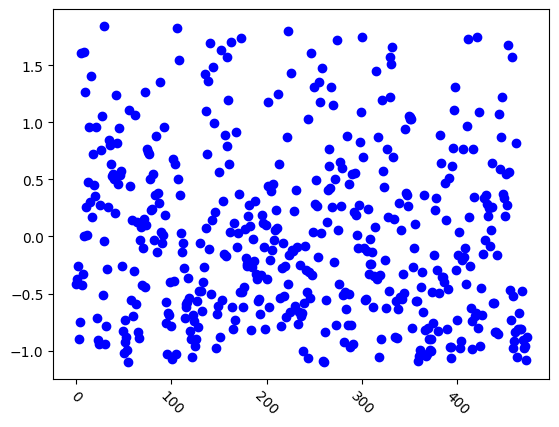

In [18]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings_matrix)

plt.xticks(rotation=-45)

indices = np.arange(len(pca_result))

plt.scatter(indices, pca_result, color="blue")

In [19]:
pca_flat = pca_result.flatten()
pca_df = results_df[["lat", "lon"]].copy()
pca_df["pca_result"] = pca_flat


pca_df

,lat,lon,pca_result
0,24.45118,54.39696,-0.417217
1,34.52813,69.17233,-0.373100
2,41.32750,19.81889,-0.258130
3,40.18111,44.51361,-0.899529
4,-8.83682,13.23432,-0.746722
...,...,...,...
469,-29.12107,26.21400,-0.904788
470,-33.92584,18.42322,-0.975073
471,-15.40669,28.28713,-0.961974
472,-17.82772,31.05337,-1.082307


In [20]:
! pip install scikit-fuzzy

## Fuzzy C means

Membership Matrix Shape: (20, 474)
Cluster Membership: [17 17 17 17 17  1 17 17  1  1  1  1  1  1  1  1  1  1  1  1  1  1 17 17
 17  1  1  1 17  0  1 17 17 17  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 17 17 17 17 17 17 17 17  1  1 17  1 17 17  1 17 14 17 17 17  1 17 17  1
  1 17  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 17 17
 17 17 17 17 17 17  1 17  1 17  1  1  1  1  7 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  1  1  1  1  1 17  1 17  1
  1  1  1 17 17 17  1 17  1 17  1  1  1 17  1  1  1  1  1  1 17 17  1 17
  1  2  1  1 17  1 17 17 17 17 17 17 17  1  1  1 17 17  7 17  1 17 17 17
 17 17 17  1  1 17 17  1 17  1  1 17 17  1  2  1  2  1  1  1  1  1 17 17
 17 17 17 17 17  1  1 17 17 17  1  2 17  1 17  1  6 17 17 17 17 17 17 17
  0 17 17  1 17 17 17  1 17  1  1  1  1  1 17  1  1  1  1 17 17 17 17  1
  1  1  1  1  1  1  1 17  1 17  1 17 17  1  1  1 17 17 17 17  1 17  1 17
 17 17  1 17  1  1  1  8  1  1  1  1  1  1 17 17 17  6  1 17 17  1 17

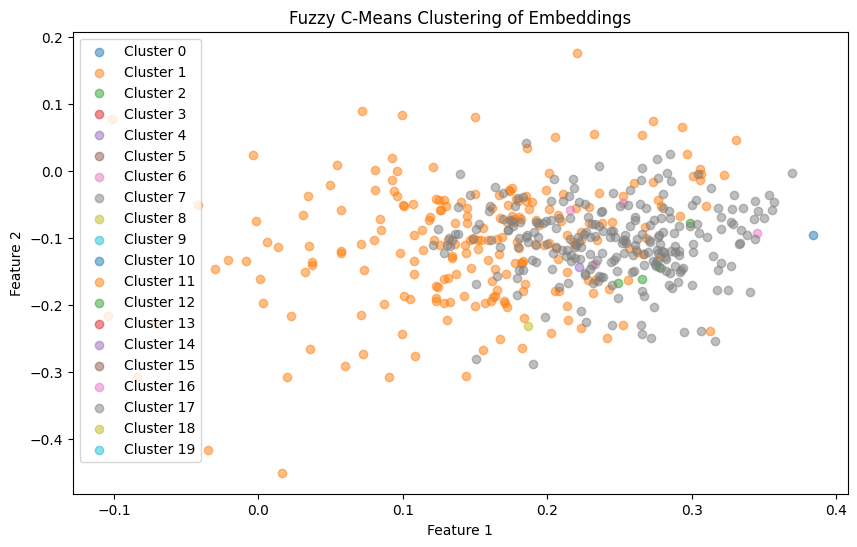

In [27]:
import skfuzzy as fuzz

n_clusters = 20  # Adjust based on your requirement

# Apply fuzzy C-means clustering
# The fuzz.cluster.cmeans function takes the following parameters:
# - data: the data points
# - c: number of clusters
# - m: fuzzy parameter (between 1 and 2)
# - error: error tolerance
# - maxiter: maximum number of iterations
# - init: initial membership matrix (optional)
# - seed: random seed for reproducibility (optional)
m = 2.0  # Fuzziness parameter
error = 0.005  # Error tolerance
maxiter = 1000  # Maximum iterations

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    embeddings_matrix.T,
    c=n_clusters,
    m=m,
    error=error,
    maxiter=maxiter,
    init=None,
    seed=42,
)


print("Membership Matrix Shape:", u.shape)

cluster_membership = np.argmax(u, axis=0)

print("Cluster Membership:", cluster_membership)

plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(
        embeddings_matrix[cluster_membership == cluster, 0],
        embeddings_matrix[cluster_membership == cluster, 1],
        label=f"Cluster {cluster}",
        alpha=0.5,
    )
plt.title("Fuzzy C-Means Clustering of Embeddings")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [30]:
pca_df["C_mean_label"] = cluster_membership

In [31]:
pca_df

,lat,lon,pca_result,K_mean_label,C_mean_label
0,24.45118,54.39696,-0.417217,14,17
1,34.52813,69.17233,-0.373100,13,17
2,41.32750,19.81889,-0.258130,18,17
3,40.18111,44.51361,-0.899529,17,17
4,-8.83682,13.23432,-0.746722,1,17
...,...,...,...,...,...
469,-29.12107,26.21400,-0.904788,17,17
470,-33.92584,18.42322,-0.975073,17,17
471,-15.40669,28.28713,-0.961974,17,17
472,-17.82772,31.05337,-1.082307,17,17


## Fuzzy K-means

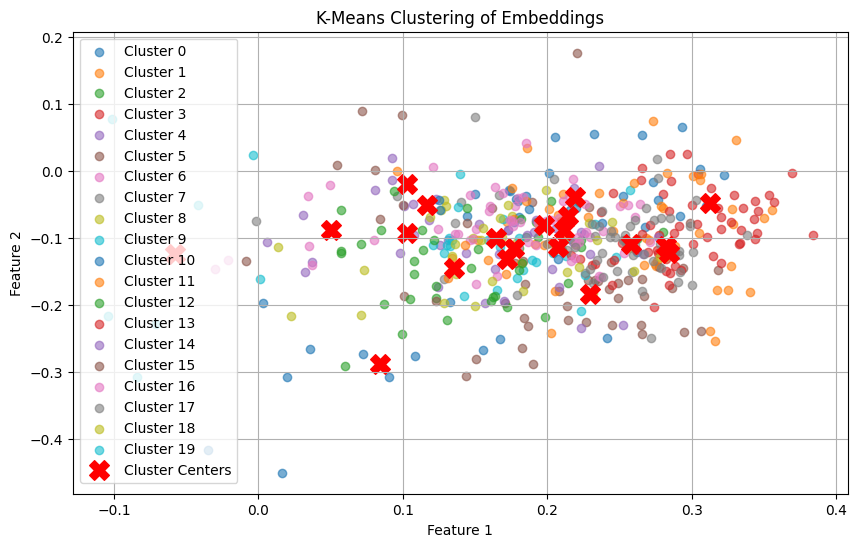

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(embeddings_matrix)

cluster_labels = kmeans.labels_

cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 6))

for cluster in range(n_clusters):
    plt.scatter(
        embeddings_matrix[cluster_labels == cluster, 0],
        embeddings_matrix[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}",
        alpha=0.6,
    )

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c="red",
    s=200,
    marker="X",
    label="Cluster Centers",
)

plt.title("K-Means Clustering of Embeddings")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

In [26]:
cluster_labels

array([14, 13, 18, 17,  1, 15, 14,  1, 10,  6, 19, 10, 10, 18, 12, 12,  4,
       10, 12, 10, 12, 12, 16, 17, 17,  5,  0,  0, 16,  1, 15, 17,  1,  1,
       11,  4,  4, 10, 10, 10, 10, 10,  0,  4, 10,  4, 10, 10, 12, 17, 16,
       17, 16, 17, 17, 17, 18, 11, 16,  1,  1,  1, 18,  1, 18, 16, 16,  9,
        1,  1,  9, 10,  6,  1, 12, 12, 12, 12,  4, 12, 10, 11, 11, 11, 11,
       11,  7, 11, 18, 11, 11, 11,  4, 14, 16, 16, 16, 16, 16, 16, 16, 16,
        7, 14, 14, 16, 15, 11, 19, 18, 14, 14, 14,  3, 14,  1,  2, 16,  2,
        2, 13, 16, 16, 16, 16, 16, 17, 13, 16, 16, 16, 16, 16, 17,  1,  8,
        0,  1,  8,  8,  9, 15, 14, 11,  8,  8, 11, 17,  9,  9, 11, 17,  6,
       13, 10, 10,  4,  9, 10,  6,  4, 10, 10, 15, 16, 16,  0, 13,  7,  5,
       18,  5,  5, 15, 13, 13,  5,  5,  5,  5,  3,  5, 14,  9, 13, 14,  5,
        5,  5,  9,  5, 13, 13, 13, 13,  5,  1, 18, 13,  5,  5,  5,  6, 13,
        5,  5,  5, 18,  5,  5,  7,  9,  7,  5, 13, 13,  9,  5, 13,  5, 16,
        5, 15,  9,  5, 13

In [24]:
pca_df["K_mean_label"] = cluster_labels

## GMM

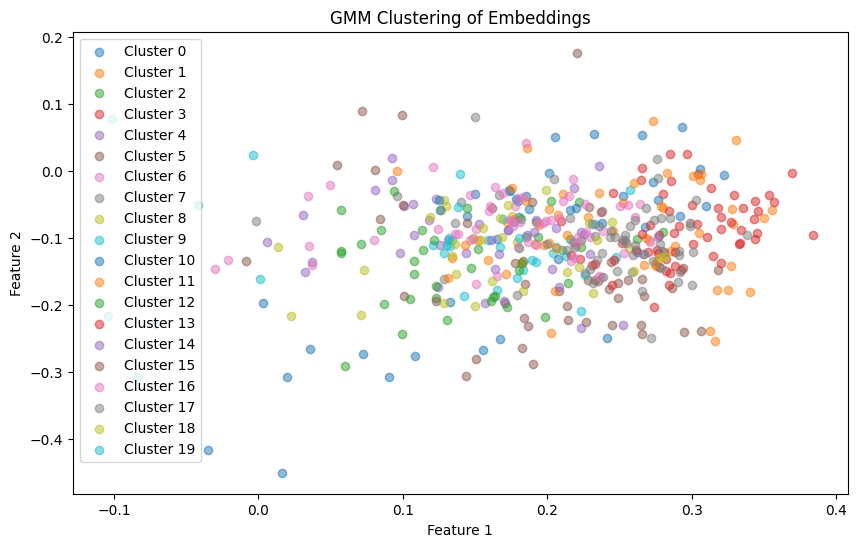

In [33]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(embeddings_matrix)

cluster_labels = gmm.predict(embeddings_matrix)

means = gmm.means_
covariances = gmm.covariances_

plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(
        embeddings_matrix[cluster_labels == cluster, 0],
        embeddings_matrix[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}",
        alpha=0.5,
    )

plt.title("GMM Clustering of Embeddings")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [35]:
pca_df["GMM_label"] = cluster_labels

In [38]:
pca_df.to_csv("image_results.csv", index=False)